In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db = mysql.connector.connect(host = "localhost",username="root",password ="arpi@1503",database="Ecommerce")
cur = db.cursor()

# list all unique cities customers are located 

In [33]:
query =""" select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017

In [4]:
query =""" select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

# Find the total sales per category

In [42]:
query =""" select upper(products.product_category) category ,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["Category","Sales"])

df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments

In [6]:
query =""" select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments
"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installemnts is",data[0][0]

('the percentage of orders that were paid in installemnts is',
 Decimal('100.0000'))

# Count the number of customers from each state

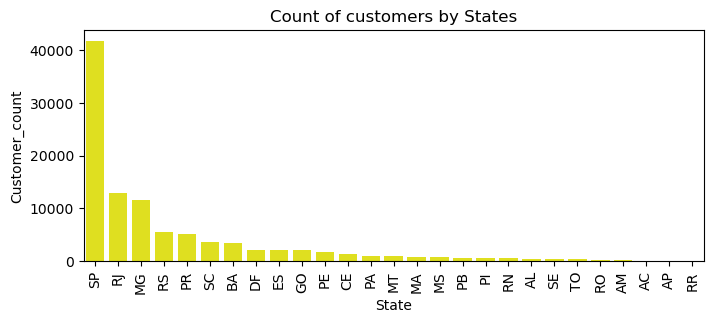

In [43]:
query =""" select customer_state,count(customer_id)
from customers group by customer_state
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["State","Customer_count"])


plt.figure(figsize=(8,3))
df =df.sort_values(by ="Customer_count",ascending =False)
sns.barplot(x = df["State"],y = df["Customer_count"],data = df,color = "yellow")
plt.xticks(rotation=90)
plt.title("Count of customers by States")
plt.show()


# Calculate the number of orders per month in 2018

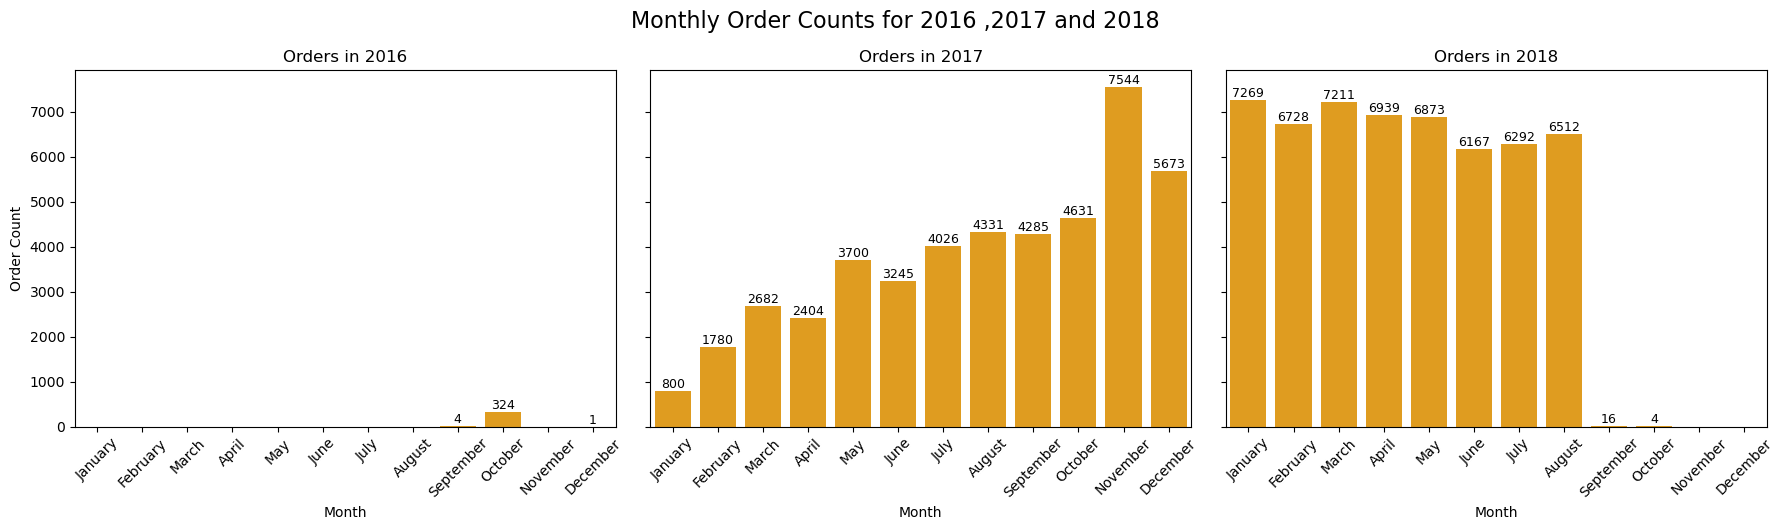

In [38]:
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)


for i, year in enumerate([2016 , 2017, 2018]):
    query = f"""
        SELECT MONTHNAME(order_purchase_timestamp) AS Month, 
               COUNT(order_id) AS Order_count
        FROM orders
        WHERE YEAR(order_purchase_timestamp) = {year}
        GROUP BY Month
    """
    cur.execute(query)
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=["Month", "Order_count"])
    
    
    ax = axes[i]
    sns.barplot(x="Month", y="Order_count", data=df, ax=ax, order=month_order, color="orange")
    ax.set_title(f"Orders in {year}")
    ax.set_xlabel("Month")
    ax.set_ylabel("Order Count" if i == 0 else "")
    ax.tick_params(axis='x', rotation=45)
    ax.bar_label(ax.containers[0], fontsize=9)

plt.tight_layout()
plt.suptitle("Monthly Order Counts for 2016 ,2017 and 2018", fontsize=16, y=1.05)
plt.show()

# Find the average number of products per order, grouped by customer city

In [35]:
query ="""with count_per_order as
(select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city c,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id =count_per_order.customer_id
group by c order by average_orders desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["City","Average products per Order"])
df.head(10)

,City,Average products per Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [10]:
query ="""select upper(products.product_category) category ,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Category","Percentage of total revenue"])
df.head(5)

,Category,Percentage of total revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased

In [11]:
import numpy as np
query =""" select products.product_category,count(order_items.product_id)
,round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category
"""
cur.execute(query)
data = cur.fetchall()
df= pd.DataFrame(data,columns=["Category","order_count","price"])
arr1 = df["order_count"]
arr2 = df["price"]
a = np.corrcoef([arr1,arr2])
print("Correlation=",a[0][1])

Correlation= -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

In [12]:
query ="""select*,dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","revenue","Rank"])
df.head(5)

,seller_id,revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5


# Calculate the moving average of order values for each customer over their order history

In [31]:
query ="""select customer_id ,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id=orders.order_id)as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["Customer_id","order_purchase_timestamp","Payment","Moving_Avg"])
df


,Customer_id,order_purchase_timestamp,Payment,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year

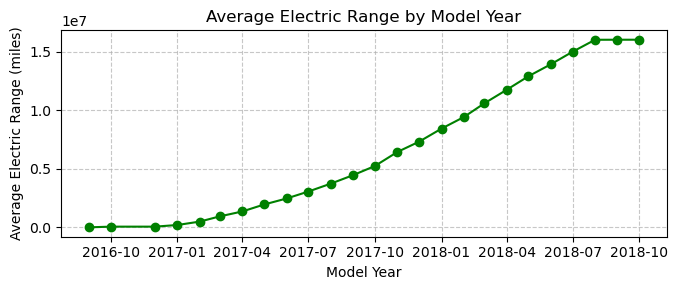

In [29]:
query ="""select years,months,payment,sum(payment)
over(order by years,months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years,months) as a

"""
cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns = ["Year","Month","Payment","cumulative_sales"])

df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))


df = df.sort_values('Date')


plt.figure(figsize=(7, 3))
plt.plot(df["Date"],df["cumulative_sales"], marker='o', linestyle='-', color='green')
plt.title('Average Electric Range by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Electric Range (miles)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate the year-over-year growth rate of total sales

In [15]:
query ="""with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years,(payment - lag(payment, 1) over(order by years))/
(lag(payment,1) over(order by years))*100 from a
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns =["Year","YoY % growth"])
df

,Year,YoY % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

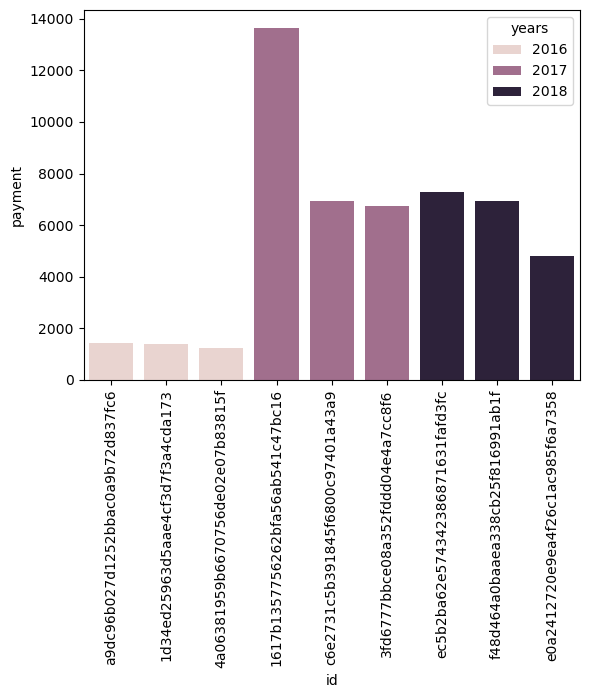

In [16]:
query ="""select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) 
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3
"""
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns =["years","id","payment","Rank"])
sns.barplot(x="id",y = "payment",data = df,hue = "years")
plt.xticks(rotation = 90)
plt.show()